### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [6]:
import sys
import os
sys.path.append(os.path.abspath("../../src/utils"))
from preprocess import *  
from plotting import *
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "../../data/embryo/raw/"
plot_dir = "../../data/embryo/plots/"
os.makedirs(plot_dir, exist_ok=True)

#### Load ATAC data and metadata

In [7]:
atac_data_path = os.path.join(data_dir, "atac_peak_matrix_complete_sparse.csv")
atac_data_df = pd.read_csv(atac_data_path)

meta_path = os.path.join(data_dir, "atac_all.metaData.txt")
atac_metadata_df = pd.read_csv(meta_path, index_col=0)


Map ATAC Cells: Assign each cell a pseudobulk, developmental stage + cell type using the authors' celltype assignment

In [14]:
atac_metadata_df = (
    atac_metadata_df
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


Aggregate accessibility signals from all cells in a pseudobulk (by pseudobulk mean)

In [4]:
atac_data_df = atac_data_df.merge(
    atac_metadata_df[['atac_cell', 'pseudobulk', 'atac_cell_type']],
    left_on='Cell', right_on='atac_cell', how='left'
)

# mean accessibility per pseudobulk
pseudobulk_matrix = (
    atac_data_df.groupby(['Peak', 'pseudobulk'])['Accessibility']
    .mean()  
    .unstack(fill_value=0)
)
# cell counts per pseudobulk
cell_counts = atac_data_df.groupby('pseudobulk')['Cell'].nunique().sort_values(ascending=False)


In [ ]:

def plot_pseudobulk_cell_read_distributions(
    atac_data_df, atac_metadata_df, save_path=None, max_pseudobulks=None, show=True
):
    cell_map = atac_metadata_df.set_index('atac_cell')[['pseudobulk', 'atac_cell_type']]
    total_per_cell = atac_data_df.groupby('Cell')['Accessibility'].sum()
    df_reads = (
        total_per_cell.rename_axis('Cell').reset_index()
        .merge(cell_map, left_on='Cell', right_index=True, how='left')
        .dropna(subset=['pseudobulk', 'atac_cell_type'])
    )
    # Optionally restrict to top N pseudobulks by cell count
    cell_counts = df_reads['pseudobulk'].value_counts()
    order = cell_counts.index.tolist()
    if max_pseudobulks:
        order = order[:max_pseudobulks]
        df_reads = df_reads[df_reads['pseudobulk'].isin(order)]
        cell_counts = cell_counts.loc[order]
    x_labels = [f"{pb}\n(n={cell_counts[pb]})" for pb in order]
    plt.figure(figsize=(32, 14))
    ax = sns.boxplot(
        data=df_reads,
        x='pseudobulk',
        y='Accessibility',
        hue='atac_cell_type',
        order=order,
        showfliers=False,
        palette='tab20'
    )
    ax.set_xticklabels(
        x_labels,
        rotation=45,
        ha='right',
        fontsize=7,
        linespacing=1.7
    )
    plt.xlabel("Pseudobulk (sorted by #cells)", fontsize=12, fontweight='bold')
    plt.ylabel("Total Reads per Cell", fontsize=12)
    plt.title("ATAC Reads per Cell by Pseudobulk and Cell Type", fontsize=16)
    plt.legend(title="Cell Type", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=250)
    if show:
        plt.show()
    else:
        plt.close()


In [ ]:
def plot_pseudobulk_cell_read_distributions(
    atac_data_df, atac_metadata_df, save_path=None, max_pseudobulks=None, show=True
):
    cell_map = atac_metadata_df.set_index('atac_cell')[['pseudobulk', 'atac_cell_type']]
    total_per_cell = atac_data_df.groupby('Cell')['Accessibility'].sum()
    df_reads = (
        total_per_cell.rename_axis('Cell').reset_index()
        .merge(cell_map, left_on='Cell', right_index=True, how='left')
        .dropna(subset=['pseudobulk', 'atac_cell_type'])
    )
    # Optionally restrict to top N pseudobulks by cell count
    cell_counts = df_reads['pseudobulk'].value_counts()
    order = cell_counts.index.tolist()
    if max_pseudobulks:
        order = order[:max_pseudobulks]
        df_reads = df_reads[df_reads['pseudobulk'].isin(order)]
        cell_counts = cell_counts.loc[order]
    x_labels = [f"{pb}\n(n={cell_counts[pb]})" for pb in order]
    plt.figure(figsize=(32, 12))
    ax = sns.boxplot(
        data=df_reads,
        x='pseudobulk',
        y='Accessibility',
        hue='atac_cell_type',
        order=order,
        showfliers=False,
        palette='tab20'
    )
    ax.set_xticklabels(
        x_labels,
        rotation=45,
        ha='right',
        fontsize=6,
        linespacing=1.7
    )
    plt.xlabel("Pseudobulk (sorted by #cells)", fontsize=12, fontweight='bold')
    plt.ylabel("Total Reads per Cell", fontsize=12)
    plt.title("ATAC Reads per Cell by Pseudobulk and Cell Type", fontsize=12)
    plt.legend(title="Cell Type", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=6)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=250)
    if show:
        plt.show()
    else:
        plt.close()


/tmp/ipykernel_1427469/463133562.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


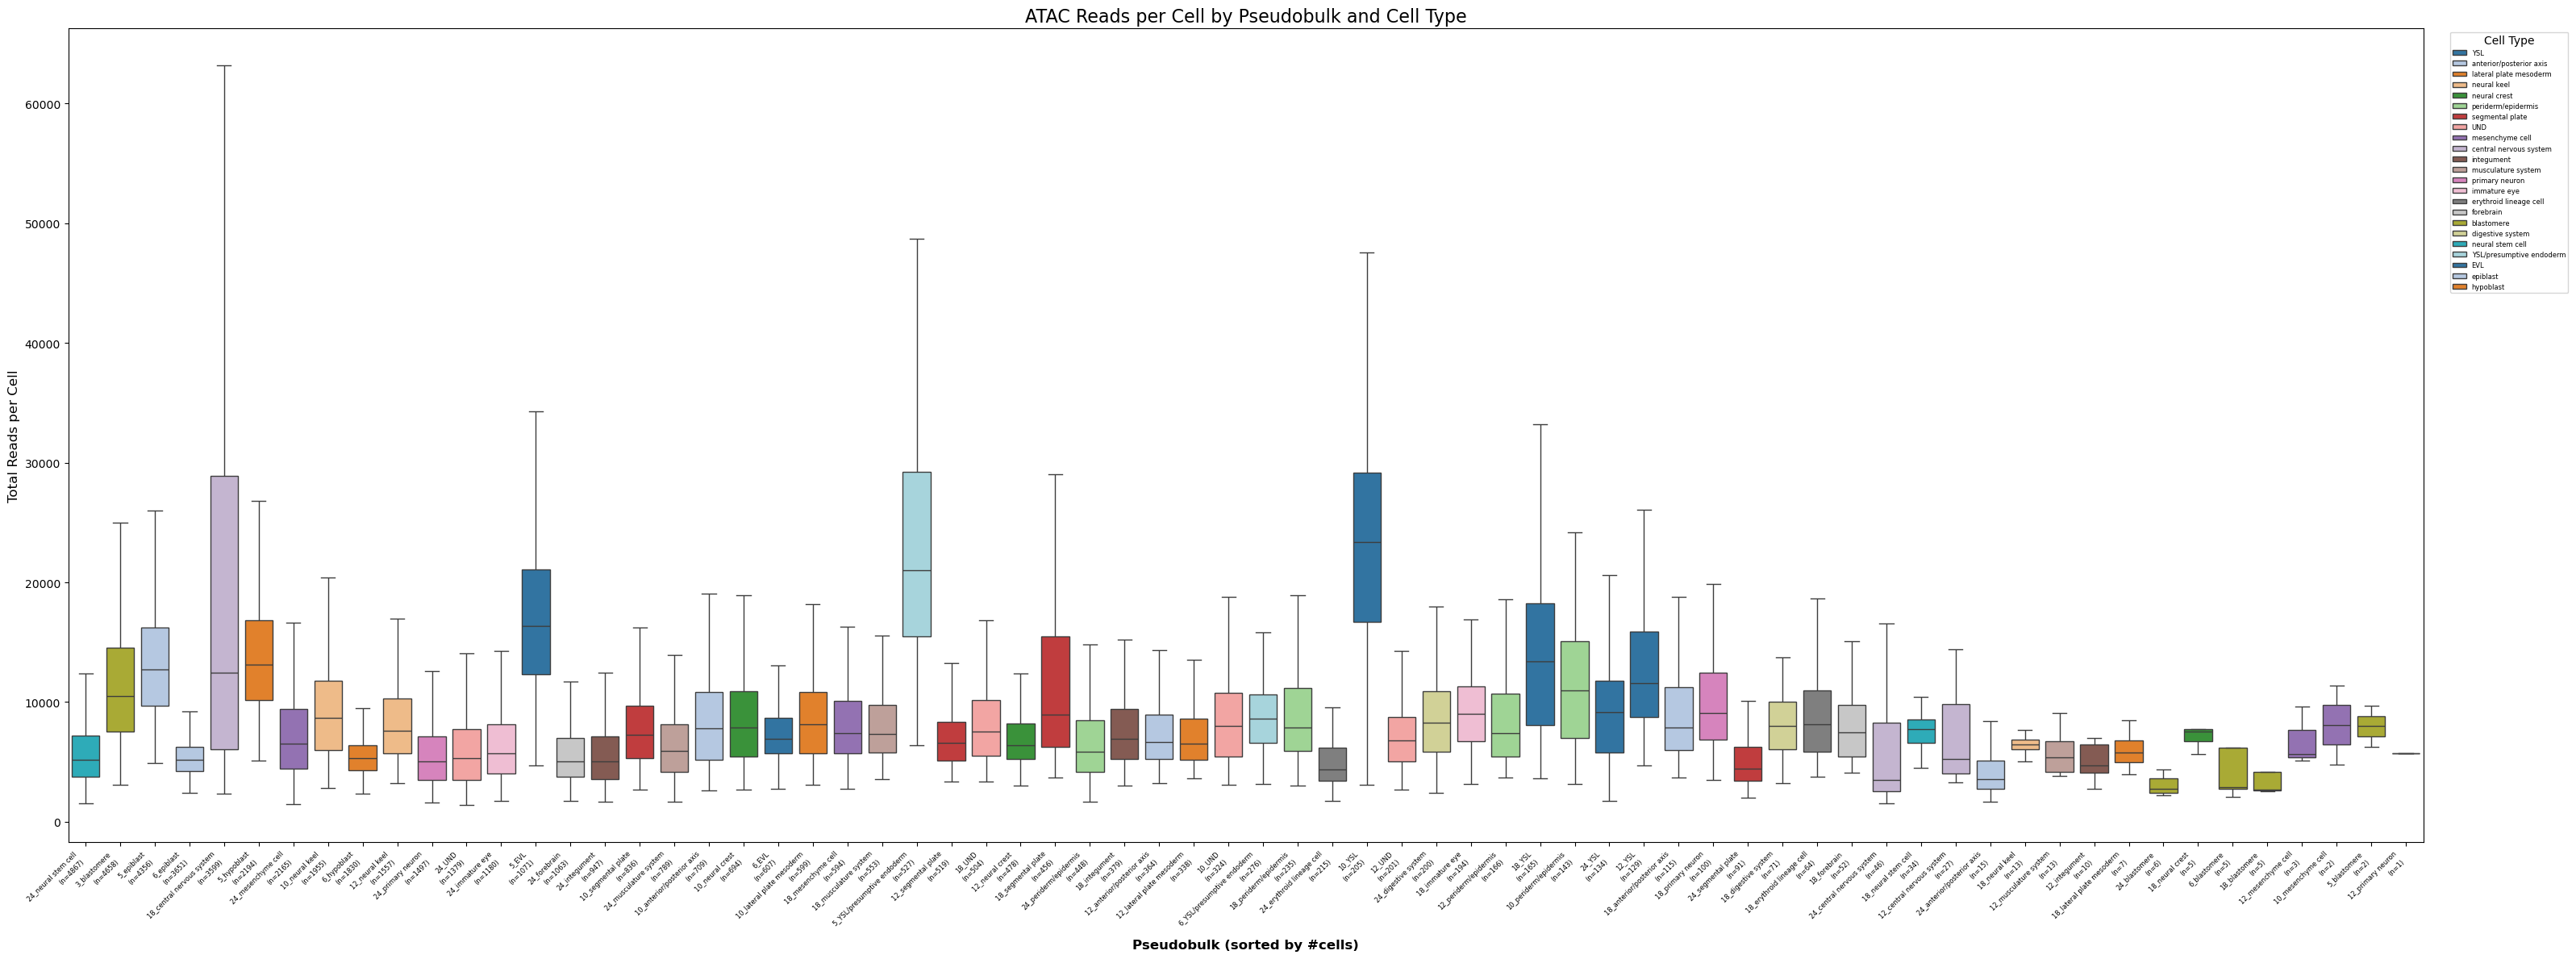

In [19]:

# Plot: boxplot of total reads per cell (per pseudobulk, colored by cell type)
plot_pseudobulk_cell_read_distributions(
    atac_data_df, atac_metadata_df,
)

# Plot: scatter (median, std, range vs n_cells), colored by celltype
plot_pseudobulk_agg_stats(
    atac_data_df, atac_metadata_df, save_dir=plot_dir
)
